In [46]:
import cv2
import os
import rosbag2_py
import datetime
import json

from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

from sensor_msgs.msg import Image
from cv_bridge import CvBridge
from deepracer_interfaces_pkg.msg import InferResultsArray, InferResults
from rclpy.serialization import deserialize_message

from deepracer_viz.gradcam.cam import GradCam
from deepracer_viz.model.model import Model
from deepracer_viz.model.metadata import ModelMetadata


In [2]:
bridge = CvBridge()


In [3]:
def get_rosbag_options(path, serialization_format='cdr'):
    storage_options = rosbag2_py.StorageOptions(uri=path, storage_id='sqlite3')

    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format=serialization_format,
        output_serialization_format=serialization_format)

    return storage_options, converter_options

In [4]:
bag_path = '/workspaces/deepracer-devel/output/reinvent_logs/deepracer-bag-20221201-165534'
metadata_json = '/workspaces/deepracer-devel/output/reinvent_logs/model/model_metadata.json'
model_pb = '/workspaces/deepracer-devel/output/reinvent_logs/model/model.pb'

In [5]:
storage_options, converter_options = get_rosbag_options(bag_path)

reader = rosbag2_py.SequentialReader()
reader.open(storage_options, converter_options)

metadata = ModelMetadata.from_file(metadata_json)
model = Model.from_file(model_pb_path=model_pb, metadata=metadata)

Device mapping: no known devices.


[INFO] [1674074640.146044092] [rosbag2_storage]: Opened database '/workspaces/deepracer-devel/output/reinvent_logs/deepracer-bag-20221201-165534/deepracer-bag-20221201-165534_0.db3' for READ_ONLY.


In [6]:
storage_filter = rosbag2_py.StorageFilter(topics=['/inference_pkg/rl_results'])
reader.set_filter(storage_filter)

first_stamp = -1
steps_data = {'steps': []}

with model.session as sess:

    cam = GradCam(model, model.get_conv_outputs())

    while reader.has_next():
        step = {}
        
        (topic, data, t) = reader.read_next()
        msg = deserialize_message(data, InferResultsArray)

        # Timestamp
        timestamp: float = (msg.images[0].header.stamp.sec + msg.images[0].header.stamp.nanosec / 1e9)

        if first_stamp == -1:
            first_stamp = timestamp
            timestamp = 0
        else:
            timestamp = timestamp - first_stamp

        step['timestamp'] = timestamp
        step['seq'] = int(msg.images[0].header.frame_id)

        # Extract original image from first camera
        cv_img = bridge.compressed_imgmsg_to_cv2(msg.images[0], desired_encoding="passthrough")
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGRA2RGB)
        step['img'] = cv_img
        
        # Find best OpenVINO Result
        step['openvino_action'] = {'action': -1, 'probability': -1}    
        step['openvino_results'] = []
        for r in msg.results:
            step['openvino_results'].append({'action': r.class_label, 'probability': r.class_prob})
            if r.class_prob > step['openvino_action']['probability']:
                step['openvino_action'] = {'action': r.class_label, 'probability': r.class_prob}

        # Process image with Tensorflow
        tf_result, grad_img = cam.process(cv_img)
        step['gradcam_img'] = grad_img
        
        step['tf_action'] = {'action': -1, 'probability': -1}    
        step['tf_results'] = []
        for i, r in enumerate(tf_result):
            step['tf_results'].append({'action': i, 'probability': r})
            if r > step['tf_action']['probability']:
                step['tf_action'] = {'action': i, 'probability': r}

        # Results
        step['results'] = []

        steps_data['steps'].append(step)

main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/truediv: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/sub: (Sub): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/kernel/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/bias/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/Conv2D: (Conv2D): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_0/BiasAdd: (BiasAdd): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/BatchnormActivationDropout_1_activation: (Relu): /job:localhost/replica:0/task:0/device:CPU:0
main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_2/k

In [7]:
df = pd.json_normalize(steps_data['steps'])
step_diff = df['seq'].max() - df['seq'].min()
print("Start time: {}".format(datetime.datetime.fromtimestamp(msg.images[0].header.stamp.sec)))
print("Loaded {} steps from {}.".format(len(df.index), step_diff))
print("Duration: {:.2f} seconds".format(df['timestamp'].max()))
print("Average FPS: {:.1f}".format(step_diff / df['timestamp'].max()))
print("Action Space: {} actions".format(len(msg.results)))

Start time: 2022-12-01 21:56:09
Loaded 770 steps from 1046.
Duration: 34.85 seconds
Average FPS: 30.0
Action Space: 17 actions


In [24]:
df['action_agree'] = np.where(df['openvino_action.action'] == df['tf_action.action'], 1, 0)
df['action_diff'] = np.abs(df['openvino_action.action'] - df['tf_action.action'])
action_analysis = df[['timestamp','seq','openvino_action.action','openvino_action.probability','tf_action.action', 'tf_action.probability', 'action_agree', 'action_diff']]
action_analysis.describe()

,timestamp,seq,openvino_action.action,openvino_action.probability,tf_action.action,tf_action.probability,action_agree,action_diff
count,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,17.415348,126836.629870,8.709091,0.602446,10.216883,0.501004,0.149351,5.045455
std,11.627368,348.893897,6.443799,0.366939,5.707292,0.346448,0.356665,4.789375
min,0.000000,126314.000000,0.000000,0.063599,0.000000,0.062329,0.000000,0.000000
25%,6.439423,126507.250000,2.000000,0.215790,4.000000,0.125200,0.000000,1.000000
50%,12.840673,126699.500000,12.000000,0.694824,12.000000,0.484089,0.000000,3.000000
75%,28.412019,127166.750000,15.000000,0.978760,15.000000,0.860383,0.000000,10.000000
max,34.854671,127360.000000,16.000000,1.000000,16.000000,1.000000,1.000000,16.000000


(array([175.,  56.,  45.,  64.,  51.,  67.,  48.,  42.,  53., 169.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

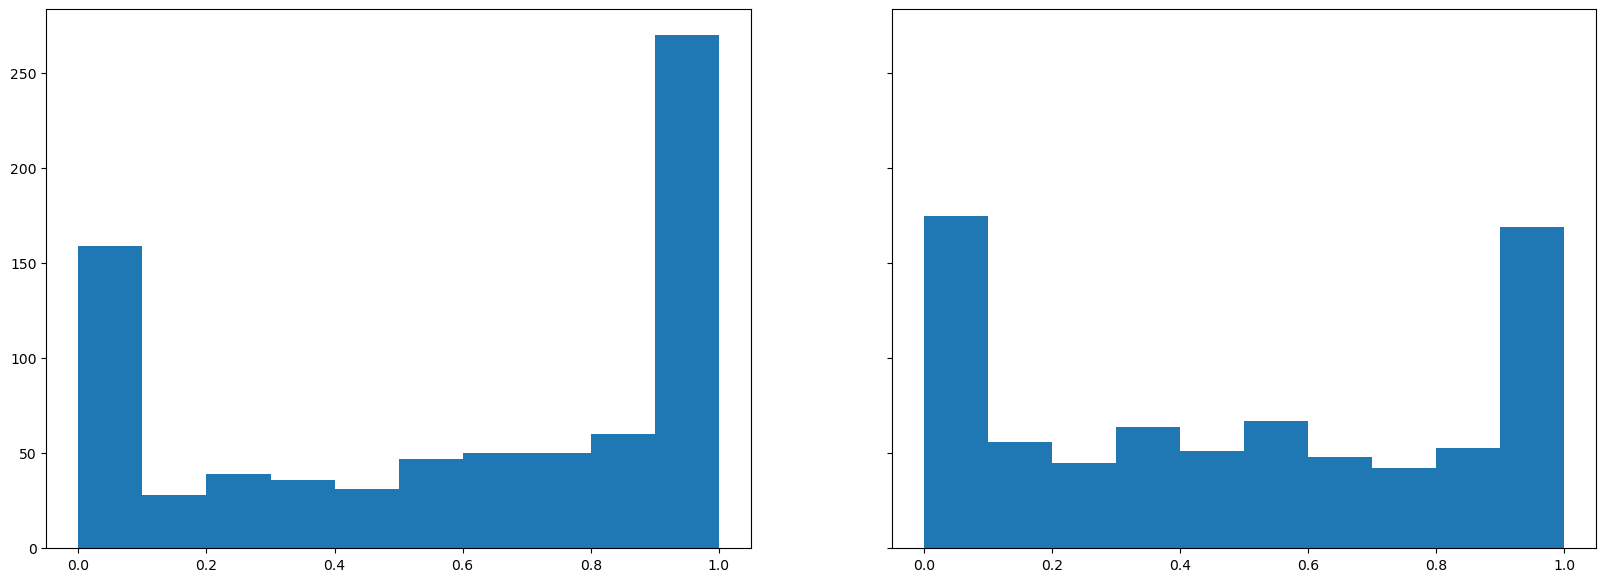

In [25]:
# Creating histogram
fig, ax = plt.subplots(1, 2, figsize =(20, 7), sharey=True)
ax[0].hist(df['openvino_action.probability'], bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax[1].hist(df['tf_action.probability'], bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

['-20.0° 1.0', '-17.5° 1.0', '-15.0° 1.0', '-12.5° 1.0', '-10.0° 1.0', '-7.5° 1.0', '-5.0° 1.0', '-2.5° 1.0', '0.0° 1.0', '2.5° 1.0', '5.0° 1.0', '7.5° 1.0', '10.0° 1.0', '12.5° 1.0', '15.0° 1.0', '17.5° 1.0', '20.0° 1.0']


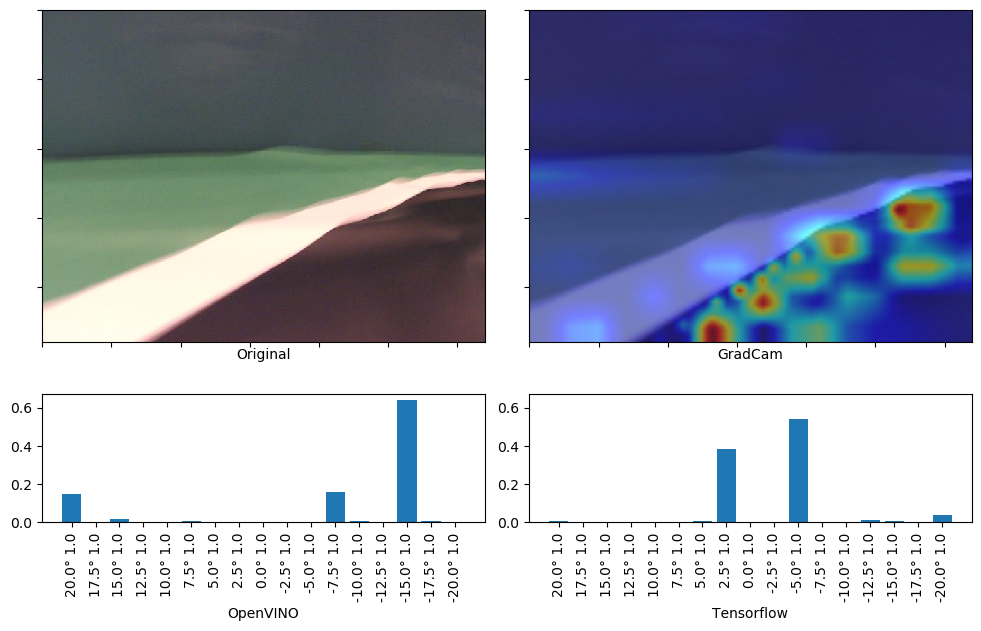

In [67]:
frame = df[df['seq']==126700]

openvino_result = df.from_dict(frame['openvino_results'].iloc[0], )
openvino_result = openvino_result.set_index('action')

tf_result = df.from_dict(frame['tf_results'].iloc[0], )
tf_result = tf_result.set_index('action')

spec = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[1, 1], wspace=0.1,
                         hspace=0.1, height_ratios=[3, 1])

action_names = []
degree_sign= u'\N{DEGREE SIGN}'

with open(metadata_json,"r") as jsonin:
    model_metadata=json.load(jsonin)
for action in model_metadata['action_space']:
    action_names.append(str(action['steering_angle'])+ degree_sign + " "+"%.1f"%action["speed"])
x = list(range(0,len(action_names)))

print(action_names)

fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(12)

ax0 = fig.add_subplot(spec[0])
ax0.imshow(frame['img'].iloc[0])
plt.setp(ax0, xlabel="Original")
plt.tick_params(labelleft = False, labelbottom=False)
ax1 = fig.add_subplot(spec[1])
ax1.imshow(frame['gradcam_img'].iloc[0])
plt.setp(ax1, xlabel="GradCam")
plt.tick_params(labelleft = False, labelbottom=False)

ax2 = fig.add_subplot(spec[2])
ax2.bar(x,openvino_result['probability'][::-1])
plt.setp(ax2, xlabel="OpenVINO")
plt.xticks(x,action_names[::-1],rotation='vertical')

ax3 = fig.add_subplot(spec[3], sharey=ax2)
ax3.bar(x,tf_result['probability'][::-1])
plt.setp(ax3, xlabel="Tensorflow")
plt.xticks(x,action_names[::-1],rotation='vertical')
plt.show()
